# Simulation companion for HTE Models' Slides
Julian Hsu
26 june 2023

The purpose of this script is to generate simulation results to support conclusions and talking point of the `HTE Models` slides. 

### Questions:
1. How does HTE performance change when you don't have the unconfoundedness assumption correct?
2. How does HTE performance change when there is no overlap in propensity score?
3. How does HTE performance change when there is overlap in propensity score, but one a feature that drive HTE? 


In [3]:
## jupyter nbconvert "HTE Models.ipynb" --to slides

In [4]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm



## Functions that generate data and estimate HTE
Create a function that allows for (1) no propensity overlap,  (2) different functions that allows for propensity overlap but not overlap in some HTE variables, and (3) separates variables used to cause propensity score and HTE data.

In [5]:
def logit_hte(y=None,x=None,w=None):
    ix = (x*2-1)
    hte = 2+10*np.exp(10*ix )/(1+np.exp(10*ix))
    hte *=w
    return hte

def single_hte(y=None,x=None,w=None):
    return w*10

def linear_hte(y=None,x=None,w=None):
    return w*(2+10*x)

def squared_hte(y=None,x=None,w=None):
    return w* 20*( 0.5 - (x-0.5)**2 + 0.25*x )
#     return w*(2+2*(x*2)**2 )

def polynomial_hte(y=None,x=None,w=None):
    return w*(2+2*(x*2)**2 - 3*(x-2) )

def friedman_hte(y=None, x=None, w=None):
    return w*( 10*np.sin(x*5) - 5*(x-2)**2 )


def dgp_nopropensity_overlap(N=1000,hte=None, 
                             propensity_ranges = {'control':[0,1],
                                                 'treatment':[0,1]}):

    ## Generate baseline outcome based on one covariate and noise
    x = np.random.uniform(0,1,N)
    y = 2 + 5*(x+5) - (5*x)**2
    y += np.random.normal(0,0.5,N)

    ## Assign treatment based on a propensity score that is a function of the one covariate above    
    x_w_noise = x/2 -0.25 + np.random.uniform(-0.5,0.5,N)
    latent_w = np.exp(x_w_noise) / (1+np.exp(x_w_noise))
        
    w = (latent_w  > 0.5).astype(float)
        
    ## Assign treatment effect and output the true counterfactuals
    w_te = hte(y=y,x=x,w=np.ones(N))

    y0_true = y[:]
    y1_true = y + w*w_te
        
        
    '''
    Now indicate treatment/control observations with propensity scores outside the ones we specify.
    re-assign propensity scores so they lie within the ranges we specify in the `propensity_ranges` dictionary.        
    '''
    within_control = (w==0) * (x >= propensity_ranges['control'][0]) * (x <= propensity_ranges['control'][1]) 
    within_treat   = (w==1) * (x >= propensity_ranges['treatment'][0]) * (x <= propensity_ranges['treatment'][1]) 
    
    return pd.DataFrame(data={'x1':x, 'y':y+w*w_te,'w':w,
                              'hte_gt':w_te,
                             'y_true0':y0_true, 'y_true1':y1_true,
                             'within_control':within_control, 'within_treat':within_treat})

def dgp_nohte_overlap(N=1000,hte=None,propensity_ranges={'control':[0,1],
                                                 'treatment':[0,1]},
                     hte_components=None,
                     hte_components_ranges=None):
    ## Reuse the outcome from the function `dgp_nopropensity_overlap` and remove the HTE.
    ## We will use a different one
    df_ = dgp_nopropensity_overlap(N=N, hte=hte, propensity_ranges=propensity_ranges)
    df_.drop(columns=['y_true1','y'],inplace=True)
    
    ## Create two different features that drive heterogeneity,
    df_['z1'] = np.random.uniform(0,1,N)
    df_['z2'] = np.random.uniform(0,1,N)
    
    '''
    Indicate the observations within the z feature ranges
    '''
    for e in hte_components_ranges.keys():
        lower_,upper_ = hte_components_ranges[e]
        df_['within_treat_'+e] = (df_[e].between(lower_,upper_) & (df_['w']==1))
        df_['within_control_'+e] = (df_[e].between(lower_,upper_) & (df_['w']==0))
        
    for e in enumerate(hte_components):
        if e[0]==0:
            df_['hte_gt'] = hte(y=df_['y_true0'],x=df_[e[1]],w=np.ones(len(df_)))

        else:
            df_['hte_gt'] += hte(y=df_['y_true0'],x=df_[e[1]],w=np.ones(len(df_)))
    
    
    ## Assign treatment effect and output the true counterfactuals    
    df_['y_true1'] = df_['y_true0'] + df_['hte_gt'] 
    df_['y'] = df_['y_true0']+ df_['hte_gt']*df_['w']
    
    return df_
    

within_treat,False,True
within_control,,
False,384,311
True,305,0


10.969087686388495


0.5

10.791791004543114


w
0.0    26.274841
1.0    27.912885
Name: y, dtype: float64

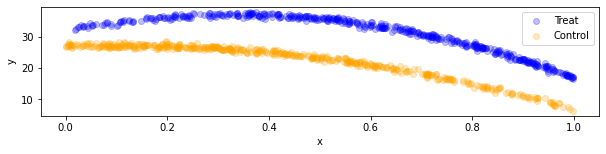

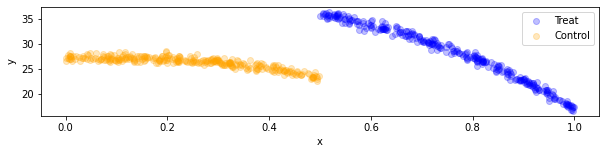

In [6]:
df = dgp_nopropensity_overlap(N=1000, 
                              hte=squared_hte, 
                              propensity_ranges = {'control':[0,0.5], 'treatment':[0.5,1]})
display( pd.crosstab(df['within_control'], df['within_treat']))
print( df['hte_gt'].mean() )
display(df['w'].mean())
df_s = df.loc[ (df['within_control']==1) | (df['within_treat']==1) ]
print( df_s['hte_gt'].mean() )
# df.describe()
display(df_s.groupby('w')['y'].mean())
for a in [df,df_s]:
    fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(10,2))
    ax.scatter(x=a.loc[a['w']==1]['x1'],
              y=a.loc[a['w']==1]['y'] ,
               alpha = 0.25,
               color='blue',
              label='Treat')
    ax.scatter(x=a.loc[a['w']==0]['x1'],
              y=a.loc[a['w']==0]['y'],
               alpha = 0.25,
               color='orange',
              label='Control')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
     

0.505

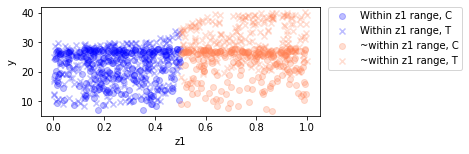

In [7]:
df = dgp_nohte_overlap(N=1000,hte=logit_hte,                  
                     hte_components=['z1'],
                     hte_components_ranges={'z1':[0,0.5], 'z2':[0.5,1]})
display(df['w'].mean())
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(5,2))
ax.scatter(x=df.loc[(df['within_control_z1']==1) & (df['w']==0) ]['z1'],
          y=df.loc[(df['within_control_z1']==1)  & (df['w']==0)]['y'] ,
           alpha = 0.25,
           color='blue',
          label='Within z1 range, C')
ax.scatter(x=df.loc[(df['within_treat_z1']==1) & (df['w']==1)]['z1'],
          y=df.loc[(df['within_treat_z1']==1)  & (df['w']==1)]['y'] ,
           alpha = 0.25,
           marker='x',
           color='blue',
          label='Within z1 range, T')

ax.scatter(x=df.loc[(df['within_control_z1']==0) & (df['w']==0) ]['z1'],
          y=df.loc[(df['within_control_z1']==0) & (df['w']==0) ]['y'] ,
           alpha = 0.25,
           color='coral',
          label='~within z1 range, C')
ax.scatter(x=df.loc[(df['within_treat_z1']==0) & (df['w']==1) ]['z1'],
          y=df.loc[(df['within_treat_z1']==0) & (df['w']==1)]['y'] ,
           alpha = 0.25,
           marker='x',
           color='coral',
          label='~within z1 range, T')

ax.set_xlabel('z1')
ax.set_ylabel('y')
ax.legend()
ax.legend(bbox_to_anchor=(1.01, 1.05))





We want to code up four different HTE models that share the same API:
1. T-Learner;
2. Doubly Robust (implicit) X-Learner;
3. OLS (as a substitute for DML); and
4. GRF.

Models 2., 3., and 4. are available in the `stnomics` package. We will manually code up model 1's `T-Learner` here.

We will code up a function that calls all the models at once, so that we can quickly iterate over these scenarios:

| # | Propensity Overlap? | HTE Dimension Overlap? |
|---|---|---|
|1 | N | N|
|2 | Y | Y|
|3 | Y | N |




In [8]:
import os as os 
from importlib import reload  # Python 3.4+

import stnomics as stn

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression

/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [9]:
nuisance_y = RandomForestRegressor(n_estimators=200)
nuisance_t = RandomForestClassifier(n_estimators=200)
nuisance_y_eln = ElasticNet()
nuisance_t_log = LogisticRegression()

In [10]:
def tlearner(data_est=None, 
             ymodel=None,
            outcome_name='y',
            treatment_name='w'):
    ## Modeling Training and Estimate counterfactuals
    rf_t = ymodel.fit(data_est['x1'].loc[data_est[treatment_name]==1].array.reshape(-1,1), data_est.loc[data_est[treatment_name]==1][outcome_name])
    y_1t = rf_t.predict(data_est['x1'].array.reshape(-1,1))

    rf_c = ymodel.fit(data_est['x1'].loc[data_est[treatment_name]==0].array.reshape(-1,1), data_est.loc[data_est[treatment_name]==0][outcome_name])
    y_0t = rf_c.predict(data_est['x1'].array.reshape(-1,1))

    ## Take the difference
    y_diff = y_1t - y_0t 
    return pd.DataFrame(data={'y0':y_0t, 'y1':y_1t, 'hte':y_diff})

def four_learners(data_ex=None):
    grf_output = stn.hte.trees.grf(data_est=data_ex,
                     feature_name=['x1','z1'],
                     outcome_name='y',
                     treatment_name='w',
                     het_feature='z1',
                     ymodel=nuisance_y,
                     tmodel=nuisance_t,
                     n_data_splits=4,
                     aux_dictionary={'criterion':'mse', 'honest':True, 'n_estimators':500})
    dr_output = stn.hte.other.DR(data_est=data_ex,
                     feature_name=['x1'],
                     outcome_name='y',
                     treatment_name='w',
                     het_feature='z1',
                     ymodel=nuisance_y_eln,
                     tmodel=nuisance_t_log,
                     n_data_splits=4,
                     aux_dictionary={'criterion':'mse', 'honest':True,
                                     'force_second_stage':'OLS',
                                    'lower':0.10, 'upper':0.90})
    ols_output = stn.hte.other.het_ols(data_est=data_ex,
                     feature_name=['x1'],
                     outcome_name='y',
                     treatment_name='w',
                     het_feature=['z1'],
                     ymodel=nuisance_y,
                     tmodel=nuisance_t,
                     n_data_splits=4,
                          force_second_stage='OLS')
    tlearner_output = tlearner(data_est = data_ex, ymodel=nuisance_y, outcome_name='y', treatment_name='w')
    return {'grf':grf_output[0], 'dr':dr_output[0], 'ols':ols_output[0], 'tlr':tlearner_output['hte'].values }


In [19]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

def plot_propensity(data=None, figname=None):
    fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(9,8))
    ax.hist(data.loc[data['w']==1]['x1'], alpha = 0.25,
               color='blue',
              label='Treat')
    ax.hist(data.loc[data['w']==0]['x1'], alpha = 0.25,
               color='orange',
              label='Control')
    ax.set_xlabel('x')
    ax.set_ylabel('Frequency')
    ax.legend()
    if figname is not None:
        plt.savefig(os.getcwd() + '/Figures/'+'{0}.png'.format(figname)
           , bbox_inches='tight')
    else:
        pass
    plt.show()
    
def plot_z1_hte(data=None, true_data=None, figname=None, offset=10):
    data['z1_rnd'] = np.round(data['z1']/offset,2)*offset
    data_g = data.groupby(['z1_rnd','w']).mean().reset_index()

    true_data['z1_rnd'] = np.round(true_data['z1']/offset,2)*offset

    true_data_g = true_data.groupby(['z1_rnd','w']).mean().reset_index()

    
    
    fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(10,10))
#     ax[0].scatter(x=data_g.loc[(data_g['within_control_z1']==1) & (data_g['w']==0) ]['z1'],
#               y=data_g.loc[(data_g['within_control_z1']==1)  & (data_g['w']==0)]['y'] ,
#                alpha = 0.55, s=150,
#                color='blue',
#               label='Within z1 range, C')
#     ax[0].scatter(x=data_g.loc[(data_g['within_treat_z1']==1) & (data_g['w']==1)]['z1'],
#               y=data_g.loc[(data_g['within_treat_z1']==1)  & (data_g['w']==1)]['y'] ,
#                alpha = 0.55, s=150,
#                marker='x',
#                color='blue',
#               label='Within z1 range, T')

#     ax[0].scatter(x=data_g.loc[(data_g['within_control_z1']==0) & (data_g['w']==0) ]['z1'],
#               y=data_g.loc[(data_g['within_control_z1']==0) & (data_g['w']==0) ]['y'] ,
#                alpha = 0.55, s=150,
#                color='coral',
#               label='~within z1 range, C')
#     ax[0].scatter(x=data_g.loc[(data_g['within_treat_z1']==0) & (data_g['w']==1) ]['z1'],
#               y=data_g.loc[(data_g['within_treat_z1']==0) & (data_g['w']==1)]['y'] ,
#                alpha = 0.55, s=150,
#                marker='x',
#                color='coral',
#               label='~within z1 range, T')
    
    ax[0].hist(data.loc[data['w']==0]['z1'], alpha=0.25, color='blue', label='Treat')
    ax[0].hist(data.loc[data['w']==1]['z1'], alpha=0.25, color='orange', label='Control')
    ax[0].set_xlabel('z1')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()
    ax[0].legend(bbox_to_anchor=(1.01, 1.05))


    ax[1].plot(true_data_g['z1'], true_data_g['hte_gt'], 
               linewidth=10, color='grey',
               alpha=0.25, label='Ground\nTruth')
    ax[1].plot(data_g['z1'], data_g['hte_grf'], linewidth=3, alpha=0.45, label='GRF')
    ax[1].plot(data_g['z1'], data_g['hte_dr'], linewidth=3,  alpha=0.45, label='DR')
    ax[1].plot(data_g['z1'], data_g['hte_ols'],linewidth=3,   alpha=0.45, label='OLS')
    ax[1].plot(data_g['z1'], data_g['hte_tlr'],linewidth=3,   alpha=0.45, label='TLR')
    ax[1].set_xlabel('z1')
    ax[1].set_ylabel('HTE')
    ax[1].legend(title='HTE Models')
    ax[1].legend(bbox_to_anchor=(1.01, 1.05))
    if figname is not None:
        plt.savefig(os.getcwd() + '/Figures/'+'{0}.png'.format(figname)
           , bbox_inches='tight')
    else:
        pass
    plt.show()

def plot_outcome(data=None):
    fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(15,2))
    ax[0].scatter(x=data.loc[data['w']==1]['x1'],
              y=data.loc[data['w']==1]['y'] ,
               alpha = 0.45,
               color='blue',
              label='Treat')
    ax[0].scatter(x=data.loc[data['w']==0]['x1'],
              y=data.loc[data['w']==0]['y'],
               alpha = 0.45,
               color='orange',
              label='Control')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].legend()
    
    ax[1].scatter(x=data.loc[data['w']==1]['z1'],
              y=data.loc[data['w']==1]['y'] ,
               alpha = 0.45,
               color='blue',
              label='Treat')
    ax[1].scatter(x=data.loc[data['w']==0]['z1'],
              y=data.loc[data['w']==0]['y'],
               alpha = 0.45,
               color='orange',
              label='Control')
    ax[1].set_xlabel('z1')
    ax[1].set_ylabel('y')
    ax[1].legend()  
    
    ax[2].scatter(x=data.loc[data['w']==1]['z1'],
              y=data.loc[data['w']==1]['hte_gt'] ,
               alpha = 0.25,
               color='blue',
              label='Treat')
    ax[2].scatter(x=data.loc[data['w']==0]['z1'],
              y=data.loc[data['w']==0]['hte_gt'],
               alpha = 0.25,
               color='orange',
              label='Control')
    ax[2].set_xlabel('z1')
    ax[2].set_ylabel('hte_gt')
    ax[2].legend()  
    
    
    plt.show()
    

#### Figures over no HTE Feature Overlap

(1355, 14) no propensity overlap


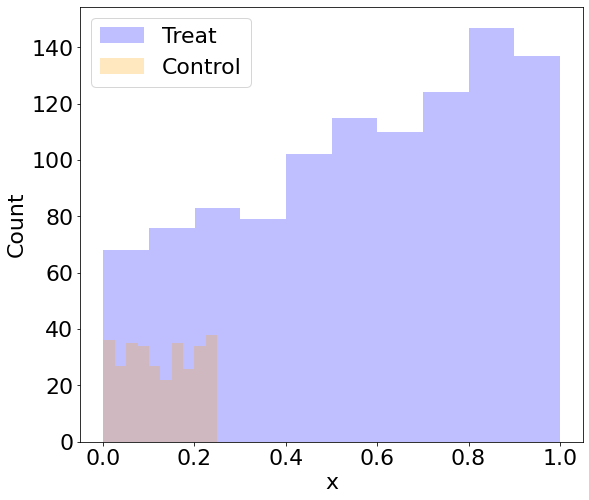

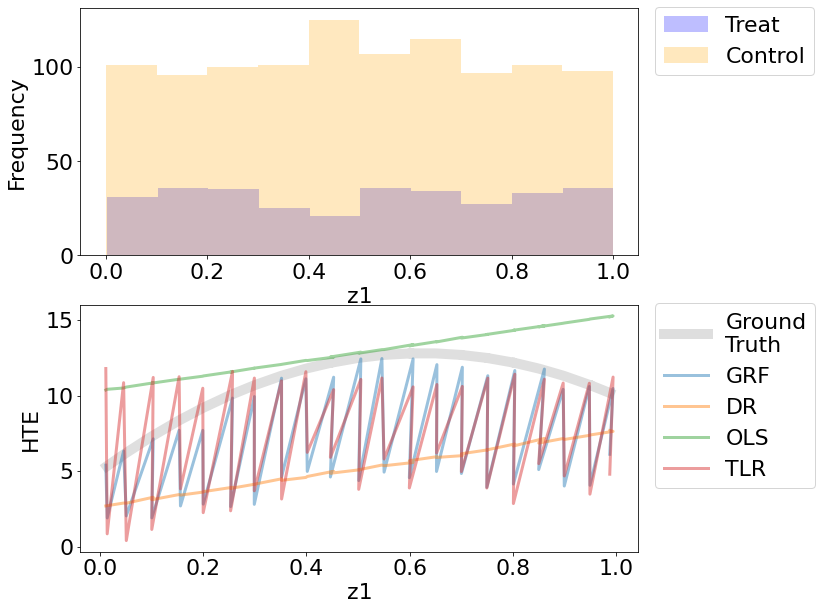

(2000, 15) nothing wrong


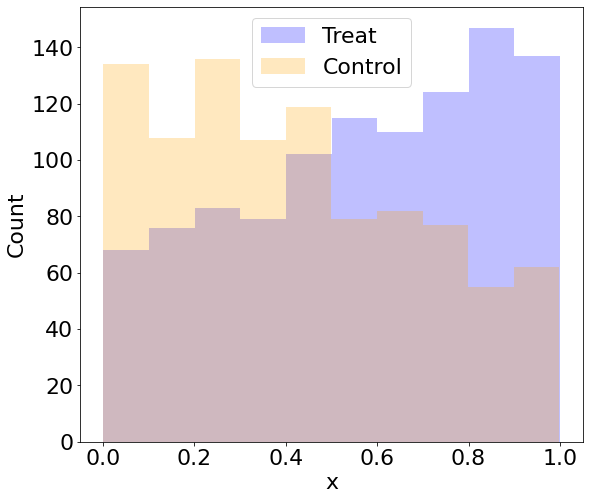

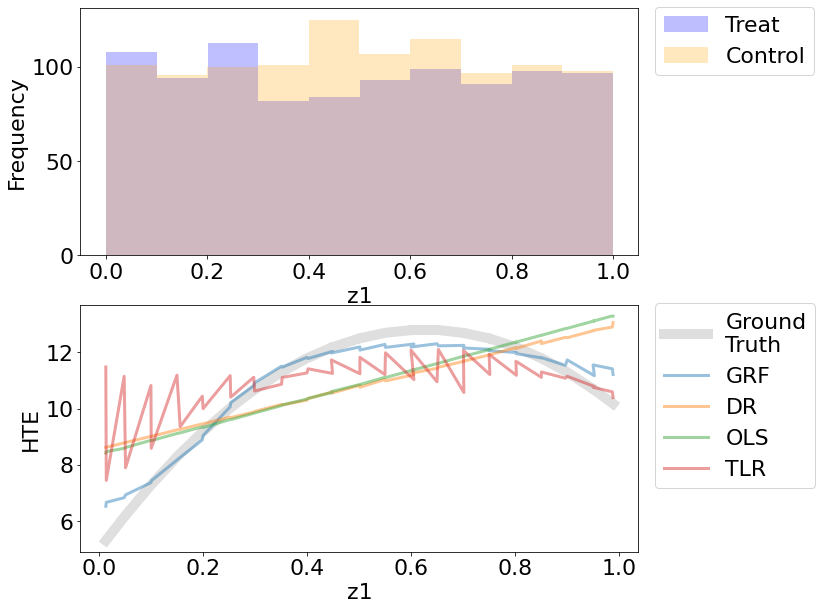

(1477, 14) no z overlap


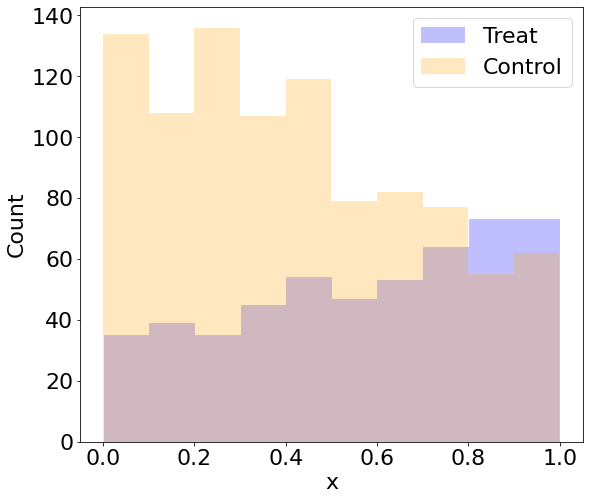

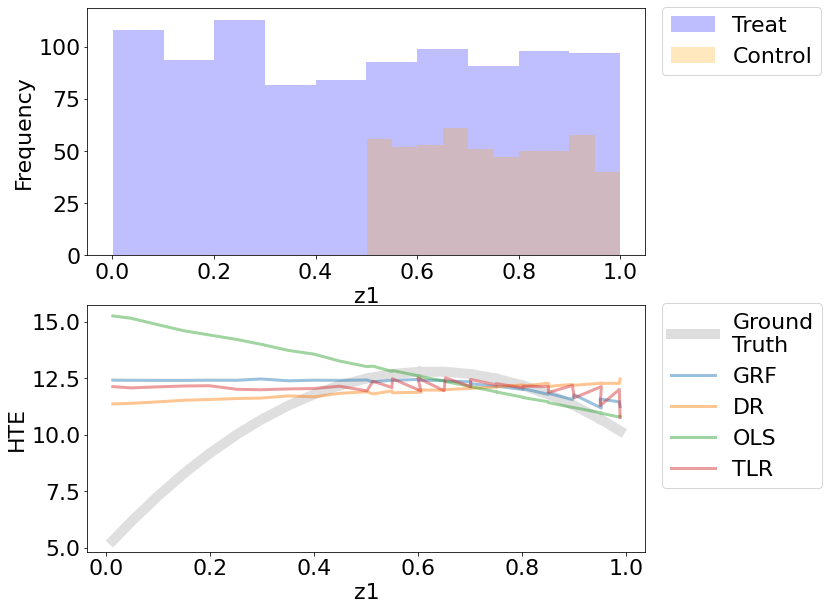

In [20]:
df = dgp_nohte_overlap(N=2000,hte=squared_hte,                  
                     hte_components=['z1'],
                     hte_components_ranges={'z1':[0,0.5], 'z2':[0.5,1]},
                      propensity_ranges = {'control':[0,0.25], 'treatment':[0,1]})
## No propensity overlap
# df0 = df.loc[(df['within_treat']==0) ]

df0 = df.loc[ (df['within_control']==1) | (df['within_treat']==1) ]


## No hte overlap
df2 = df.loc[df['within_treat_z1']==0]


for d,name in zip([df0,df,df2],['no propensity overlap','nothing wrong','no z overlap']):
    print(d.shape, name)
    
    m_output = four_learners(d)
    d['hte_grf'] = m_output['grf']
    d['hte_dr'] = m_output['dr']
    d['hte_ols'] = m_output['ols']
    d['hte_tlr'] = m_output['tlr']

    plot_propensity(data=d, figname='HTE_Figure11_propensity_{0}'.format(name))
    plot_z1_hte(data=d,true_data=df, figname='HTE_Figure11_hte_{0}'.format(name), offset=5)
    # print( df[['hte_grf','hte_dr','hte_ols','hte_tlr','hte_gt']].describe() )
    # print( df[['hte_grf','hte_dr','hte_ols','hte_tlr','hte_gt']].corr()['hte_gt'] )

#### Figures over different HTE Functions

logit


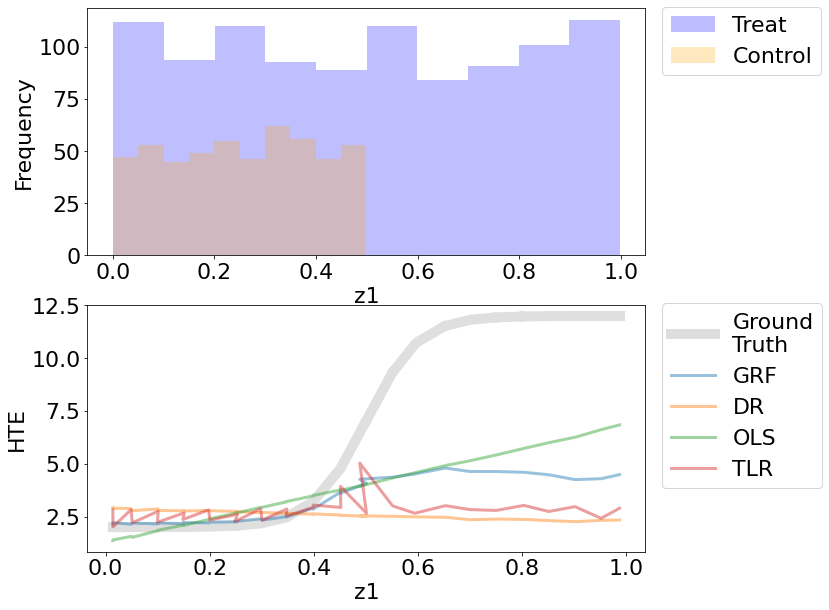

single


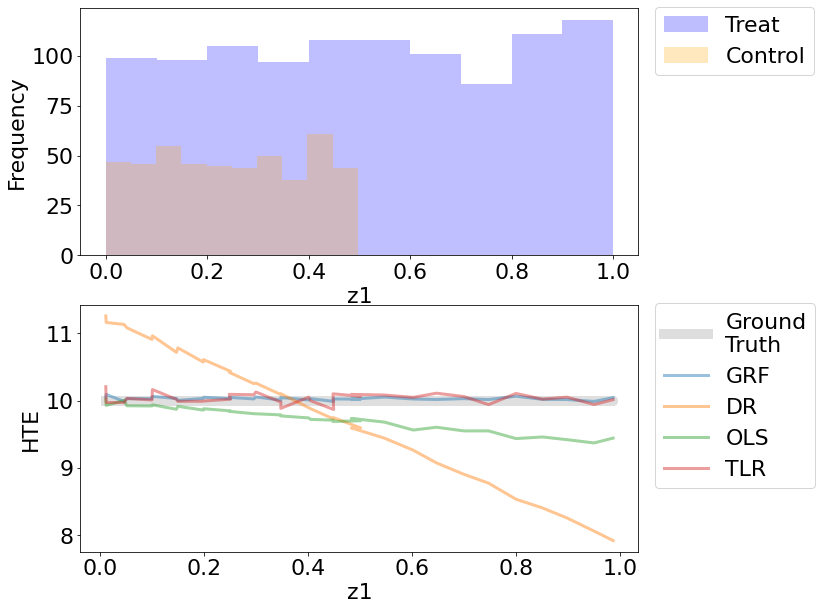

linear


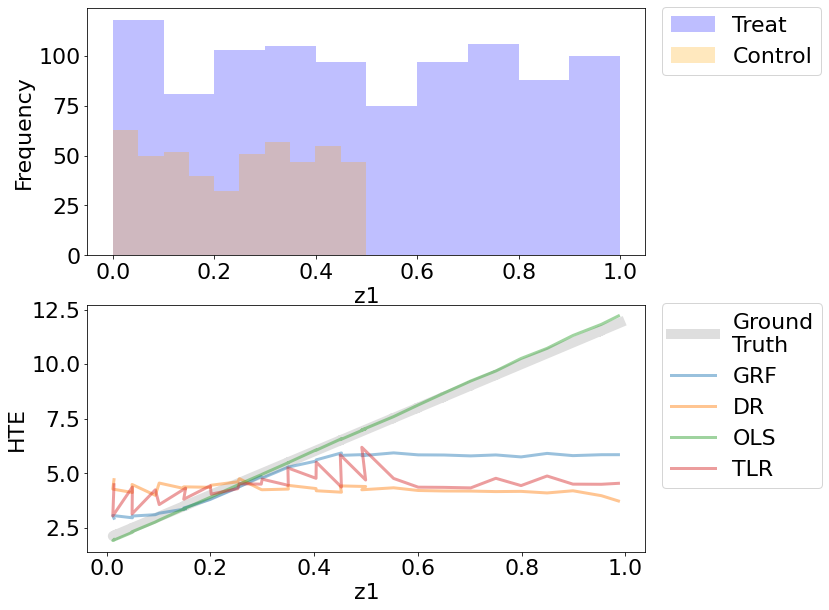

squared


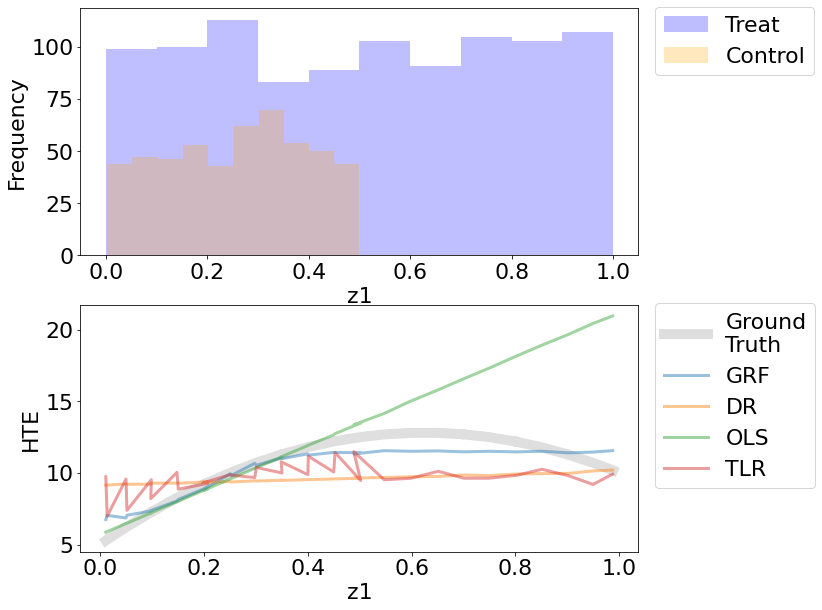

polynomial


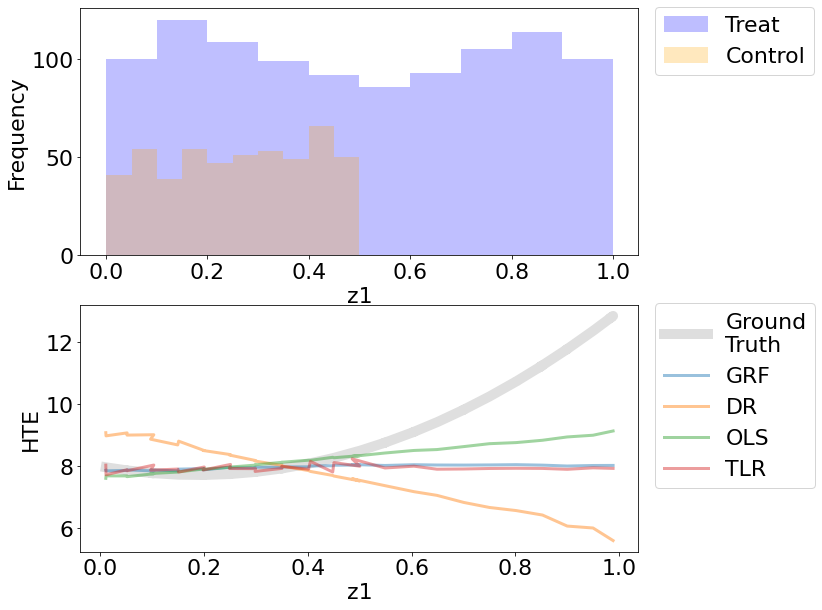

friedman


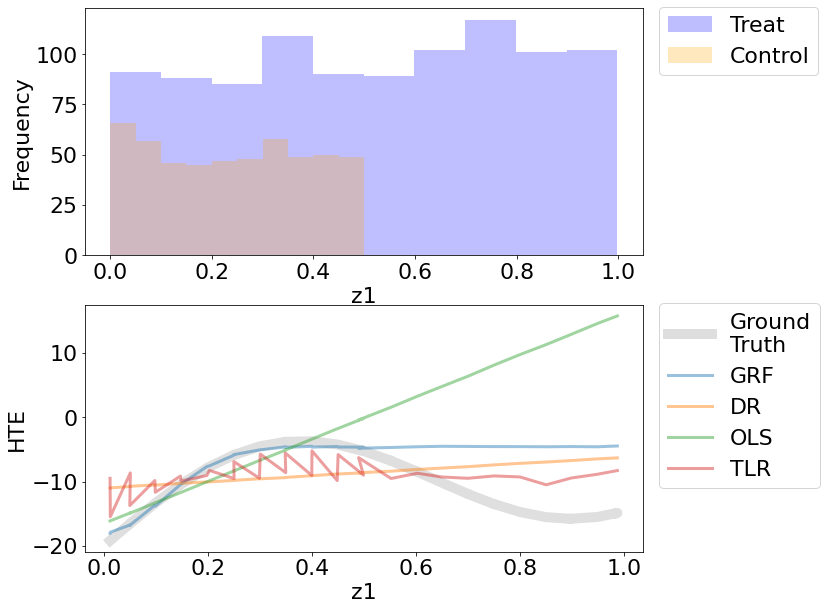

In [21]:
for hte_type,func in zip(
    ['logit','single','linear','squared','polynomial','friedman'],
    [logit_hte,
        single_hte,
        linear_hte,
        squared_hte,
        polynomial_hte,
        friedman_hte]):
    df = dgp_nohte_overlap(N=2000,hte=func,                  
                         hte_components=['z1'],
                         hte_components_ranges={'z1':[0.5,1.0], 'z2':[0.5,1]},
                          propensity_ranges = {'control':[0,0.5], 'treatment':[0.5,1]})
    print(hte_type)
#     plot_outcome(data=df)
    df2 = df.loc[df['within_treat_z1']==0]

    m_output = four_learners(df2)
    df2['hte_grf'] = m_output['grf']
    df2['hte_dr'] = m_output['dr']
    df2['hte_ols'] = m_output['ols']
    df2['hte_tlr'] = m_output['tlr']

#     plot_propensity(data=df2)
    plot_z1_hte(data=df2,true_data=df, figname='HTE_Figure12_hte_{0}'.format(hte_type), offset=5)
    # print( df[['hte_grf','hte_dr','hte_ols','hte_tlr','hte_gt']].describe() )
    # print( df[['hte_grf','hte_dr','hte_ols','hte_tlr','hte_gt']].corr()['hte_gt'] )